<a href="https://colab.research.google.com/github/jaime-garvey/web_personalization_portfolio/blob/master/notebooks/01_Preprocessing_EDA_Google_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing Google Analytics Data

# Imports

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import pandas as pd

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import pandas as pd
from pandas.io.json import json_normalize
import ast
import json

#Visualization
import matplotlib.pyplot as plt

#plt.style.use('seaborn-white')
#plt.style.use('fivethirtyeight')
%matplotlib inline

In [0]:
pd.set_option('display.max_colwidth', -1)

## Import Data (Method 1: Flatten)

In [0]:
id = '1mGi2ZF8OKq4pSFcHU0IVpnXeBXSZTKOo'

In [0]:
# #the columns that will be parsed to extract the fields from the jsons

cols_to_parse = ['device', 'geoNetwork', 'totals', 'trafficSource']

def read_parse_dataframe(file_id):
  #full path for the data file
    
  downloaded = drive.CreateFile({'id':file_id}) 
  downloaded.GetContentFile('Filename.csv')  
    
  #read the data file, convert the columns in the list of columns to parse using json loader,
  #convert the `fullVisitorId` field as a string
  data_df = pd.read_csv('Filename.csv', converters={column: ast.literal_eval for column in cols_to_parse}, dtype={'fullVisitorId': 'str'})
  
  hits_df = data_df['hits']
    
  
  #parse the json-type columns
  for col in cols_to_parse:
    #each column became a dataset, with the columns the fields of the Json type object
    json_col_df = json_normalize(data_df[col])
    json_col_df.columns = [f"{col}_{sub_col}" for sub_col in json_col_df.columns]
    #we drop the object column processed and we add the columns created from the json fields
    data_df = data_df.drop(col, axis=1).merge(json_col_df, right_index=True, left_index=True)
  return data_df, hits_df

In [0]:
traffic_sample, traffic_sample_hits = read_parse_dataframe(id)

** Set Index for Visit ID, Full Visitor ID **

In [0]:
traffic_sample = traffic_sample.set_index(['visitId', 'fullVisitorId']);

In [0]:
traffic_sample.index

MultiIndex(levels=[[1470034812, 1470035066, 1470035081, 1470035161, 1470035170, 1470035292, 1470035429, 1470035457, 1470035501, 1470035521, 1470035660, 1470035742, 1470035832, 1470035833, 1470035892, 1470036291, 1470036371, 1470036498, 1470036672, 1470036782, 1470036877, 1470036980, 1470037053, 1470037191, 1470037277, 1470037282, 1470037296, 1470037302, 1470037326, 1470037369, 1470037420, 1470037559, 1470037642, 1470037730, 1470037733, 1470037804, 1470037989, 1470038276, 1470038422, 1470038462, 1470038712, 1470038799, 1470038895, 1470039056, 1470039214, 1470039388, 1470039423, 1470039780, 1470039979, 1470039998, 1470040289, 1470040320, 1470040405, 1470040406, 1470040426, 1470040645, 1470040701, 1470040751, 1470040837, 1470040917, 1470040922, 1470040946, 1470040969, 1470041012, 1470041040, 1470041199, 1470041240, 1470041267, 1470041288, 1470041295, 1470041359, 1470041361, 1470041378, 1470041442, 1470041491, 1470041543, 1470041583, 1470041604, 1470041640, 1470041675, 1470042067, 14700422

### Process Hits Column (TBC)

In [0]:
hits_test = traffic_sample_hits

In [0]:
hits_df = traffic_sample.hits.dropna().apply(pd.Series)

In [0]:
def process_hit_column(data_df, hits_df):
    new_hits_df = hits_df.to_frame(hits_df)
    
    new_hits_df.set_index(index=data_df.index)
    #each column became a dataset, with the columns the fields of the Json type object
    #json_col_df = json_normalize(hits_df[col])
    #json_col_df.columns = [f"{col}_{sub_col}" for sub_col in json_col_df.columns]
    
    #we drop the object column processed and we add the columns created from the json fields
    #hits_df = data_df.drop(col, axis=1).merge(json_col_df, right_index=True, left_index=True)
    
    return new_hits_df

In [0]:
#hits = traffic.hits.dropna().apply(pd.Series)
traffic_sample_hits.set_index(traffic_sample.index)

AttributeError: ignored

## Import Data (Method 2: Seperate Tables)

In [0]:
id = '1mGi2ZF8OKq4pSFcHU0IVpnXeBXSZTKOo'

In [0]:
def make_dataframes(file_id):
  #List of columns with dictionaries
  cols_to_parse = ['device', 'geoNetwork', 'totals', 'trafficSource', 'hits',
               'customDimensions']
  
  other_cols = ['visitorId', 'visitNumber', 'visitStartTime','date','userId',
                'channelGrouping', 'socialEngagementType']
  
  
  downloaded = drive.CreateFile({'id':file_id}) 
  downloaded.GetContentFile('Filename.csv')  
    
  #read the data file, convert the columns in the list of columns to parse using json loader,
  #convert the `fullVisitorId` field as a string
  data_df = pd.read_csv('Filename.csv', converters={column: ast.literal_eval for column in cols_to_parse}, dtype={'fullVisitorId': 'str'})
  
  
  #Set multilevel index for data frame
  data_df.set_index(['visitId', 'fullVisitorId'], inplace=True)
  
  #make dataframe for columns with dictionaries
  #d= {col: data_df[col].dropna().apply(pd.Series) for col in cols_to_parse}
  
  d= {}
  
  for col in cols_to_parse:
    d[col] = data_df[col].dropna().apply(pd.Series)
  
  #Make last dataframe (without nested dictionary colums)
  
  visitors = data_df[other_cols]
  
  
  #return d, visitors
  
  return d, visitors
 
  

In [0]:
features, visitors = make_dataframes(id)

### Flatten JSON Columns
(totals, trafficSource, device, geoNetwordk, customDimensions, hits)

# Preprocessing

### Feature Descriptions

| Feature      | Description |
|-------------------|--------------------|
|channelGrouping |The channel via which the user came to the Store. |
|date | The date on which the user visited the Store.|
|device |The specifications for the device used to access the Store.|
|fullVisitorId| A unique identifier for each user of the Google Merchandise Store.|
|geoNetwork|This section contains information about the geography of the user.|
|sessionId | A unique identifier for this visit to the store.|
|socialEngagementType | Engagement type, either "Socially Engaged" or "Not Socially Engaged".|
|totals |This section contains aggregate values across the session.|
|trafficSource |This section contains information about the Traffic Source from which the session originated.|
|visitId | An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.|
|visitNumber |The session number for this user. If this is the first session, then this is set to 1.|
|visitStartTime -|The timestamp (expressed as POSIX time).|

### Converting to Datetime

In [0]:
##Helper function to make datetime objects

def get_datetime(visitors_df):
  #Convert date column to datetime object
  visitors_df['date'] = pd.to_datetime(visitors_df['date'])
  
  #Convert visitStartTime to datetime
  visitors_df['visitStartTime'] = pd.to_datetime(visitors_df['visitStartTime'], unit='s')
  
  return visitors_df


In [0]:
visitors = get_datetime(visitors)

# EDA

## Missing Values

**Idea:** What percent of values are missing for our features? For a predictive model, which features may not be worth while to pursue?

In [0]:
#Helper function to check for missing data
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return df.loc[~(df['Total']==0)]

In [0]:
## function to create dictionary of mission data

def missing_data_dict(features, visitors):
  dict = {}
  
  #missing value results for features
  for key in features.keys():
    dict[key] = missing_data(features[key])
    
  #results for visitors dataframe
  dict['visitors'] = missing_data(visitors)
    
  
  return dict

In [0]:
missing_data_dict = missing_data_dict(features, visitors)

## Customer Profile

**Goal:** Understand the some high-level characteristics of our visitors.

1. What are some of the top channels?
2. What devices are they interacting with the site on?
3. What browsers are used?
4. Where are visitors located?

### Users by Channel

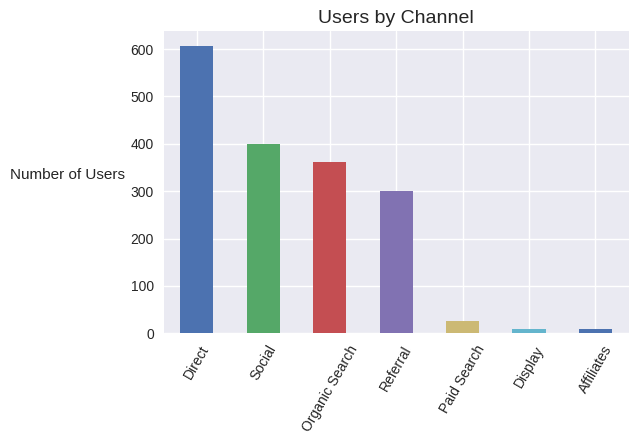

In [0]:
plt.figure(dpi=100)
visitors.channelGrouping.value_counts().plot(kind='bar')
plt.title('Users by Channel', fontsize=14)
plt.xticks(rotation=60)
plt.ylabel('Number of Users', rotation='horizontal', ha='right');

### Traffic Source Medium

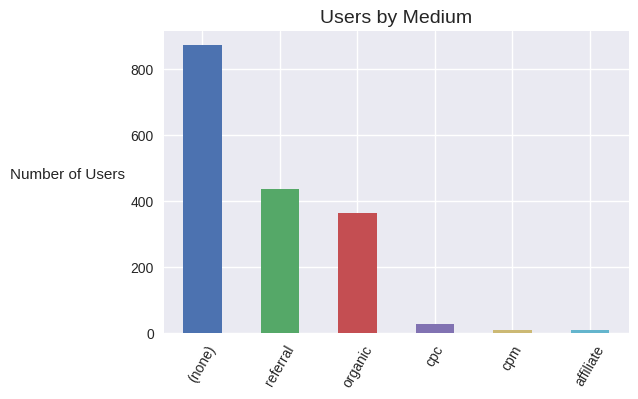

In [0]:
plt.figure(dpi=100)
features['trafficSource'].medium.value_counts().plot(kind='bar')
plt.title('Users by Medium', fontsize=14)
plt.xticks(rotation=60)
plt.ylabel('Number of Users', rotation='horizontal', ha='right');

### Browser

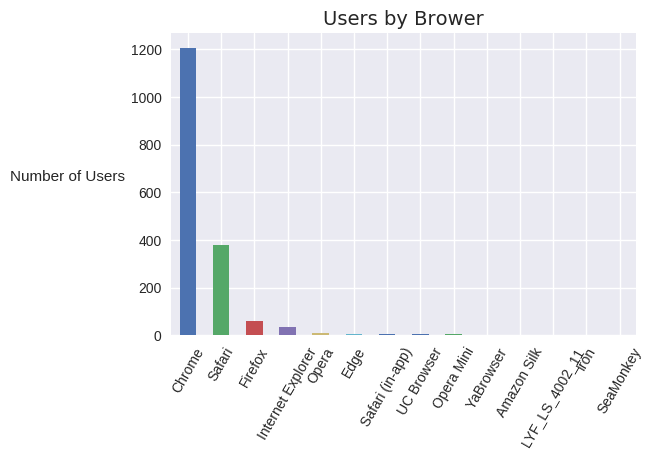

In [0]:
plt.figure(dpi=100)
features['device'].browser.value_counts().plot(kind='bar')
plt.title('Users by Brower', fontname="Tahoma", fontsize=14)
plt.xticks(rotation=60)
plt.ylabel('Number of Users', rotation='horizontal', ha='right');

### Users by Devices

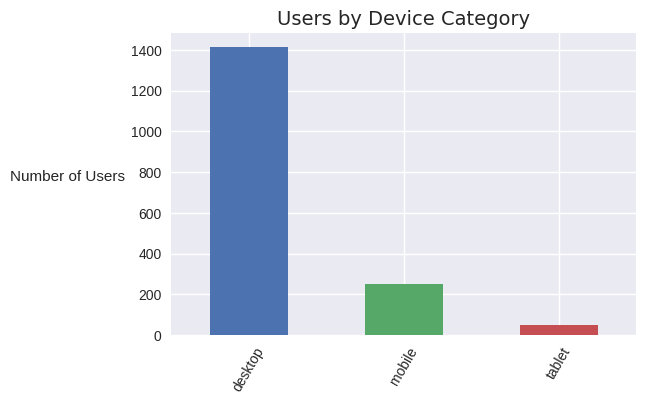

In [0]:
plt.figure(dpi=100)
features['device'].deviceCategory.value_counts().plot(kind='bar')
plt.title('Users by Device Category', fontname="Tahoma", fontsize=14)
plt.xticks(rotation=60)
plt.ylabel('Number of Users', rotation='horizontal', ha='right');

### Users by Location

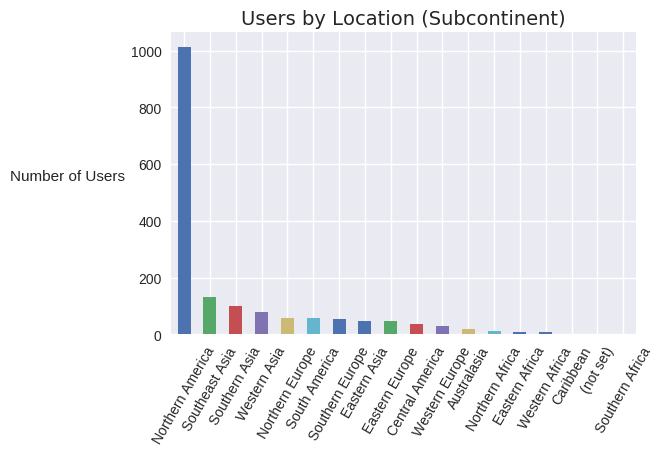

In [0]:
#location = geoNetwork.groupby(['continent', 'subContinent'])['subContinent'].count().unstack('subContinent').fillna(0)

plt.figure(dpi=100)
features['geoNetwork'].subContinent.value_counts().plot(kind='bar')
plt.title('Users by Location (Subcontinent)', fontname="Tahoma", fontsize=14)
plt.xticks(rotation=60)
plt.ylabel('Number of Users', rotation='horizontal', ha='right');

## Revenue

### Non-zero Transactions Revenue

In [0]:
percent_nonzero = len(features['totals'].transactionRevenue[features['totals'].transactionRevenue >0])/len(features['totals'].transactionRevenue)*100

print("Percent of Non-zero Transactions: {0:.2f}%".format(percent_nonzero))

Percent of Non-zero Transactions: 1.99%
